In [62]:
import pandas as pd
import numpy  as np

import data file

In [63]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [64]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df2.iloc[:135,:]
df2_2 = df2.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

# shuffle data
train = train.sample(frac=1)
test  = test.sample(frac=1)

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 48)


In [65]:
print("Non-cheat in trainsets: ", len(train[train['Label']==0]))
print("Cheat in trainsets: ", len(train[train['Label']==1]))

Non-cheat in trainsets:  111
Cheat in trainsets:  111


parse data from string to numpy array

In [66]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [67]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [68]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [70]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [71]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [72]:
label_train = np.array(label_train)

In [73]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [74]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

print(x_train)

print(y_train)

tf.Tensor(
[[[  65.993   22.949   69.87  ...   57.723    9.713   58.535]
  [  55.833   25.881   61.539 ...   48.576    5.925   48.936]
  [  28.501   49.513   57.13  ...   61.875   11.066   62.856]
  ...
  [ -41.72   138.56  -144.705 ...  -22.782  102.161 -104.67 ]
  [ -79.843  122.197 -145.97  ...  -74.414   90.164 -116.906]
  [-116.467   81.392 -142.089 ...  -89.412   68.336 -112.536]]

 [[ -63.742   59.408  -87.134 ...  -45.634   51.714  -68.97 ]
  [ -30.939   51.1    -59.737 ...  -43.43    56.994  -71.656]
  [ -29.896   63.65   -70.321 ...  -40.061   71.416  -81.885]
  ...
  [  30.51     2.326   30.599 ...   54.583   -0.284   54.584]
  [  20.305   46.073   50.349 ...   27.139    7.288   28.101]
  [  12.979   81.508   82.534 ...   11.95    86.49    87.312]]

 [[ -42.552   38.305  -57.253 ...  -26.13    30.001  -39.785]
  [ -19.796   29.458  -35.492 ...  -51.314   24.949  -57.057]
  [ -17.043   31.953  -36.214 ...  -52.825   35.015  -63.376]
  ...
  [ -13.743   30.13   -33.117 ...   1

Train the model

In [75]:
model = init_model()
# callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
callbacks = [History()]
history = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100


e:\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 3s 131ms/step - loss: 0.7441 - accuracy: 0.4369
Epoch 2/100
2/2 [==============================] - 0s 123ms/step - loss: 0.6758 - accuracy: 0.5946
Epoch 3/100
2/2 [==============================] - 0s 120ms/step - loss: 0.6605 - accuracy: 0.6036
Epoch 4/100
2/2 [==============================] - 0s 120ms/step - loss: 0.6454 - accuracy: 0.6261
Epoch 5/100
2/2 [==============================] - 0s 126ms/step - loss: 0.6251 - accuracy: 0.6622
Epoch 6/100
2/2 [==============================] - 0s 122ms/step - loss: 0.6148 - accuracy: 0.6577
Epoch 7/100
2/2 [==============================] - 0s 128ms/step - loss: 0.6081 - accuracy: 0.6622
Epoch 8/100
2/2 [==============================] - 0s 120ms/step - loss: 0.5929 - accuracy: 0.6982
Epoch 9/100
2/2 [==============================] - 0s 129ms/step - loss: 0.5843 - accuracy: 0.7297
Epoch 10/100
2/2 [==============================] - 0s 125ms/step - loss: 0.5679 - accuracy: 0.7387
Epoch 11/100
2/2 [===

In [76]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1294, 12)
(None, 647, 12)
(None, 647, 12)
(None, 323, 12)
(None, 12)
(None, 12)
(None, 2)


Predict test set

In [77]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [78]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [79]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[   2.098   52.175   52.217 ...   25.628   34.073   42.635]
  [   7.004   59.978   60.386 ...   25.792   31.371   40.612]
  [  19.542   47.84    51.677 ...   39.696   31.051   50.398]
  ...
  [ 145.264   12.427  145.795 ...  113.833  -13.212  114.597]
  [ 158.544    3.374  158.58  ...  126.277  -13.677  127.015]
  [ 114.636   36.751  120.383 ...   97.978   -6.843   98.216]]

 [[ -27.516   22.849  -35.766 ...  -12.209   -3.605  -12.73 ]
  [ -25.854   22.016  -33.958 ...  -11.692   -6.423  -13.34 ]
  [ -21.245   21.301  -30.085 ...   -8.279   -8.201  -11.653]
  ...
  [  -3.626   24.487  -24.754 ...   20.879   -0.782   20.893]
  [  -2.413   27.096  -27.204 ...   21.862    0.319   21.864]
  [   1.427   23.134   23.178 ...   25.473   -1.327   25.507]]

 [[  36.532   19.706   41.508 ...   38.296   -1.999   38.348]
  [  38.632   17.085   42.242 ...   37.323   -2.345   37.396]
  [  52.381   10.931   53.51  ...   46.978   -1.939   47.018]
  ...
  [  12.631   25.466   28.426 ...   1

In [80]:
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

2/2 [==============================] - 1s 18ms/step
[1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 0 0
 1 0 1 1 1 0 1 1 0 1 1]
[1 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1
 0 0 1 0 1 0 1 0 0 1 1]
Accuracy on test set:  0.6041666666666666


In [81]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [82]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

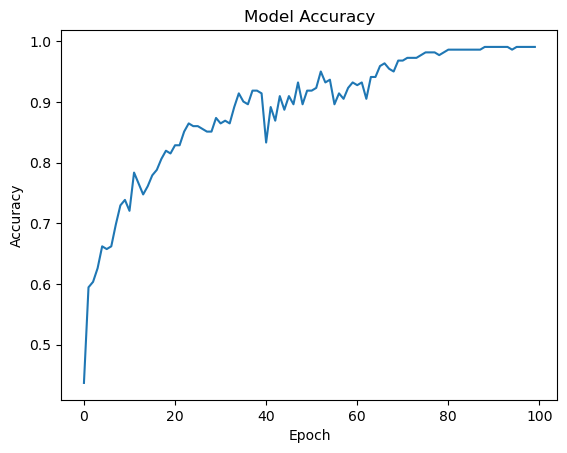

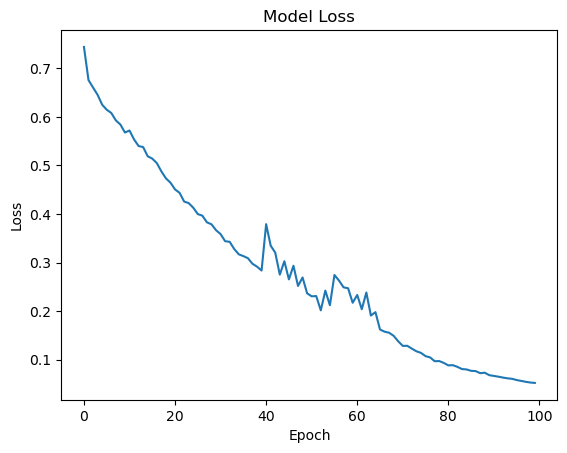

In [83]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [84]:
model.save('GP038.keras')